### Подготовительный этап.

In [2]:
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
import osmnx as ox
import networkx as nx
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import csv
import json # пока писать будет в json, но если что переделаем

Выгрузим граф Уфы с помощью библиотеки osmnx

In [0]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

#fig, ax = ox.plot_graph(G, save=True, close=True, file_format='png', filename='Ufa', dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

In [0]:
# создадим список всех точек графа
nodes_list = list(G.nodes()) 

In [0]:
# пишем узлы в csv
nodes_df = pd.DataFrame(nodes_list)
nodes_df.to_csv('nodes.csv', index=False)

По-хорошему, тут нужно создать матрицу и лист смежности


In [0]:
# нахождение расстояний между смежными узлами 
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [0]:
# пишем список смежности в csv
adj_list = nx.generate_adjlist(G, delimiter=' ')
with open('adjacency_list.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=' ')
    for line in adj_list:
        writer.writerow(line)

In [0]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
# G_pd.to_csv('matrix_adjacency_pandas.csv')

In [0]:
# переводив в нампаевский ndarray
# !запускать только один раз!
G_pd = G_pd.values

In [29]:
print(G_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

Штука внизу не работает, потому что мы дикты создаем только ниже (Оксана)

In [0]:
# вместо нулей и единиц записываем в матрицу смежности расстояния между нодами (по формуле из файла)
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# если ребра между нодами нет, то заполняем большими расстояниями (для нахождения крастчайших путей)
# возможно, можно придумать что-то менее костыльное
        if G_pd[i][j] == 0:
            G_pd[i][j] = 10**10

NameError: ignored

Выбираем M больниц и N домов

In [0]:
# вытаскиваем все больницы и дома

buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

hospitals = []
apartments = []
build = buildings['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospitals.append(key)
    elif value == 'apartments':
        apartments.append(key)


In [0]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node

In [0]:
# оставим только уникальные значения G
temp = hospitals_dict.copy()
hospitals_dict = {}

for key, value in temp.items():
  if value not in hospitals_dict.values():
    hospitals_dict[key] = value

temp = apartments_dict.copy()
apartments_dict = {}

for key, value in temp.items():
  if (value not in apartments_dict.values()) and (value not in hospitals_dict.values()):
    apartments_dict[key] = value

In [0]:
M = 10
N = 100

hospitals_dict = dict(random.sample(list(hospitals_dict.items()), M))
apartments_dict = dict(random.sample(list(apartments_dict.items()), N))

Создадим несколько структур данных для работы впоследствии

In [0]:
# Создаем словарь {id узла}: {его index в списке узлов} 
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [0]:
# делаем листы для использования Дейсктры 
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [0]:
# создаем общий лист, чтобы сделать и дома, и больницы одновременно
new_nodes = apartments_values + hospital_values
new_nodes = np.array(new_nodes)

In [0]:
# матрица в которой будем хранить значения кратчайших путей
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

In [0]:
'''
nodes_list - лист со всеми точками графа G
nodes_numbers - {id узла}: {его index в списке узлов}

hospitals_dict, apartments_dict - словари, ключ - точка из footsprint, значение - точка G
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())
new_nodes = apartments_values + hospital_values

'''

Дейкстра, использующая кучу

In [0]:
from heapq import heappush, heappop

def dijkstra_heap (G, source):
    
    G_succ = G._succ 

    push = heappush
    pop = heappop
    weight = lambda d: min(attr.get(weight, 1) for attr in d.values()) #понятия не имею что происходит в этой строчке увы

    seen = {}  # минимальное расстояние до ключа-точки  
    tree = {}
    # fringe is heapq with 2-tuples (distance,node)
    fringe = []

    seen[source] = 0
    push(fringe, (0, source, None))

    while fringe:

        (d, v, pred) = pop(fringe)

        if v in tree:
            continue  # already searched this node.

        tree[v] = {}
        tree[v]['node'] = v
        tree[v]['dist'] = d
      
        if pred != None:

          if len(tree[pred]['path']) > 0:
            tree[v]['path'] = (tree[pred]['path']).copy()
            tree[v]['path'].append(pred)      
          else:
            tree[v]['path'] = [pred]
        else:
          tree[source]['path'] = []

        for u, e in G_succ[v].items():
            cost = weight(e) #e - ребро (мультиграф же,значит их несколько, выбираем наименьший вес)

            if cost is None: # видимо если ребра нет, возможно стоит заменить на бесконечное значение
                continue

            vu_dist = tree[v]['dist'] + cost
             
            if u not in seen or vu_dist < seen[u]: #если мы еще не искали путь до u или новое расстояние меньше найденного              
                seen[u] = vu_dist
                push(fringe, (vu_dist, u, v))
    return tree

Запуск Дейкстры



In [0]:
import time

big_tree_dict = {}
start = time.time()

for i in range(len(new_nodes)):
    tree = dijkstra_heap(G, new_nodes[i])
    big_tree_dict[new_nodes[i]] = tree

print(time.time() - start)

Это дерево еще понадобится, так что я бы его куда-нибудь тоже скачала (хотя оно большое)

---
Я вроде записала (Оксана)


In [0]:
with open('big_tree.csv', 'w') as f:
    for key in big_tree_dict.keys():
        f.write("%s,%s\n"%(key, big_tree_dict[key]))

Уменьшаем дерево до точек N+M

In [0]:
# удалим ненужные точки сделав из большого дерева кратчайших путей малое дерево мощности N+M

small_tree_dict = big_tree_dict.copy()

for tree_key, tree in big_tree_dict.items():

  keys = list(tree.keys())
  small_tree = tree.copy()

  for key in keys:
    if key not in new_nodes:
      del small_tree[key]

  keys = list(small_tree.keys())

  for key in keys:
    temp = small_tree[key]['path'].copy()
    for el in temp:
      if el not in new_nodes:
        small_tree[key]['path'].remove(el)

  small_tree_dict[tree_key] = small_tree

Матрица кратчайших путей для N+M точек

In [0]:
  for i in range(N+M):  
    tree = small_tree_dict[new_nodes[i]]
    for j in range(N+M): 
        short_path_matrix[i][j] = tree[new_nodes[j]]['dist']   

In [0]:
 short_path_matrix

array([[  0., 117., 106., ..., 120., 123., 133.],
       [117.,   0., 185., ...,  30.,  33., 111.],
       [107., 195.,   0., ..., 209., 212., 233.],
       ...,
       [113.,  31., 179., ...,   0.,   3., 126.],
       [116.,  34., 182., ...,   3.,   0., 126.],
       [115., 107., 215., ..., 121., 124.,   0.]])

In [0]:
# записываем матрицу кратчайших путей в csv
with open('matrix_dijkstra.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in short_path_matrix:
        writer.writerow(line)

In [0]:
# ставим вместо 0 - 10**10
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0:
            short_path_matrix[i][j] = 10**10

Создадим лист смежности дерева для более удобного взаимодействия

In [0]:
small_tree_dict_adj = {}

# беру пути до каждой точки и из них дерево в формате вершина: (ребенок, длина ребра)
for root, tree in  tree_dict.items():

  seen = {}
  new_tree = {}

  for node in tree:
    new_tree[node] = []

  for node in tree:

    if node in seen:
      continue

    seen[node] = 1
    #path = tree[node]['path']
    path = tree[node]['path']

    for i in range(1,len(path)):
      if path[i] in seen:
        continue
      seen[path[i]] = 1
      new_tree[path[i-1]].append((path[i], tree[path[i-1]]['dist'] - tree[path[i]]['dist']))

    if(len(path) > 0):
      new_tree[path[len(path) - 1]].append((node, tree[node]['dist'] - tree[path[len(path) - 1]]['dist']))

    small_tree_dict_adj[root] = new_tree

Матрицы смежности для разных узлов

In [0]:
# сделать матрицу смежности из получившихся деревьев

def make_adj_m (tree, nodes):
  adjancecy_m = np.zeros((110, 110))
  for node in nodes:
    for child, dlina in tree[node]:
      adjancecy_m[np.where(nodes == node)[0][0]][np.where(nodes == child)[0][0]] = dlina
  return adjancecy_m

In [0]:
# можно сделать и скачать все матрицы смежности

adjancecy_m_dict = {}

for node in new_nodes:
  tree = tree_dict[node]
  adjancecy_m = make_adj_m (tree, new_nodes)
  adjancecy_m_dict[node] = adjancecy_m.copy()
  adjancecy_m_pd = pd.DataFrame(data = adjancecy_m, index = new_nodes, columns = new_nodes)
  #adjancecy_m_pd.to_csv('adjancecy_m_'+str(new_nodes[100])) #не хочу качать сейчас


**Визуализация** дерева кратчайших путей для точки 3448891642

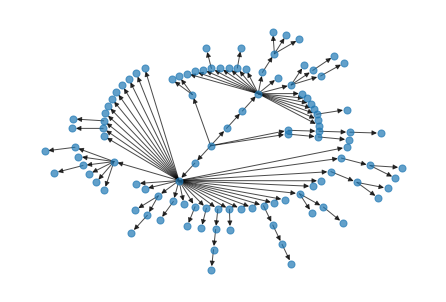

In [0]:
small_adjancecy = adjancecy_m_dict[new_nodes[0]]

new_G = nx.from_numpy_matrix(small_adjancecy, create_using = nx.DiGraph)

# рисую граф
from networkx.drawing.nx_pydot import graphviz_layout
pos = graphviz_layout(new_G, prog='twopi')
nx.draw(new_G, pos, node_size = 50, alpha = 0.7)

Нам нужен json?

---
Ну прост дерево выглядит нагляднее в json, чем в csv. Но если мы можем красиво записать в csv, то не нужен. **ЕЩЕ ВАЖНО** предлагаю как-нибудь скачать картинки деревьев в png/jpeg/etс, так удобнее будет показывать имхо (Оксана)


In [0]:
 #пишем в json файл дерево кратчайших путей
 with open('short_path_tree.json', 'w') as f:
     json.dump(tree_dict, f)

In [0]:
 with open('short_path_tree.json', 'r') as fr:
     head = [next(fr) for _ in range(20)]
     print(head)

In [0]:
# пишем в json все кратчайшие пути
with open('short_paths.json', 'w') as f:
    json.dump(short_paths, f)

А это?

---
Если в твоих функциях дальше нигде не используется, то не нужно (Оксана)


In [0]:
# получение ключа 
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

# получение айди
def get_id(nodes_numbers, index_nodes, i):
    temp = get_key(nodes_numbers, index_nodes[i])
    if temp == -1:
        return "Не найдено id узла"
    else:
        return temp

Всякое разное (понадобится далее)

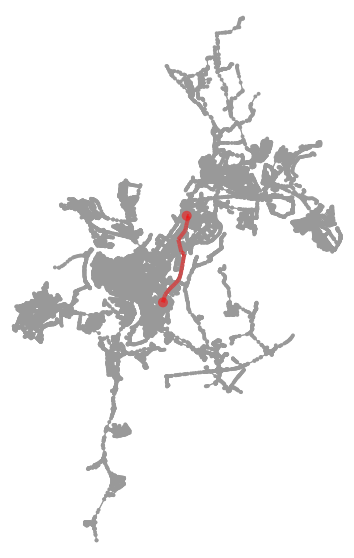

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35bb997ef0>)

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
route = nx.shortest_path(G,
                         892683760,
                         498826321, 
                         weight='length') 

ox.plot_graph_route(G, route, fig_height=10, fig_width=10)

### Первое задание.

In [0]:
#from numpy import genfromtxt
# считываем матрицу кратчайших расстояний из csv файла
# data = genfromtxt('/content/matrix_dijkstra.csv', delimiter=',') 

# можно загрузить эту матрицу если она есть в оперативке
data = short_path_matrix

### Пункт 1.а 
Для каждого дома определить ближайший от узла объект (путь “туда”), ближайший к объекту узел (путь “обратно”), объект, расстояние до которого и обратно минимально (“туда и обратно”).

In [0]:
# функция нахождения ближайшей больницы
def find_nearest_hospitals(dist_matrix, apart_count=100):
    nearest_hosp_list = [[-1 for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        nearest_hosp_list[i][0] = np.argmin(dist_matrix[i][apart_count:]) + apart_count
        nearest_hosp_list[i][1] = np.argmin(np.array(dist_matrix[apart_count:]).transpose()[i]) + apart_count
        tuda = dist_matrix[i][apart_count:]
        suda = np.array(dist_matrix[apart_count:]).transpose()[i]
        nearest_hosp_list[i][2] = np.argmin(tuda + suda) + apart_count
    return nearest_hosp_list

In [0]:
# запуск программы
find_nearest_hospitals(data)

In [0]:
nearest_hosp_list = [[0 for i in range(3)] for j in range(M)]
temp = short_path_matrix2.copy()
for i in range(M+N):
  if new_nodes[i] in apartments_dict:
    for j in range(M+N):
      if new_nodes[j] in apartments_dict:
        temp[i][j] = 10**10

for i in range(M):
  node = apartments_values[i]
  index = np.where(new_nodes == node)
  # туда
  nearest_hosp_list[i][0] = new_nodes[np.reshape(temp[index][:], 110).argmin()]
  # обратно
  nearest_hosp_list[i][1] = new_nodes[np.reshape(temp[:][index], 110).argmin()]
  #туда и обратно
  nearest_hosp_list[i][2] = new_nodes[(np.reshape(temp[index][:], 110) + 
                              np.reshape(temp[:][index], 110)).argmin()]
                              

In [0]:
nearest_hosp_list

NameError: ignored

In [0]:
apartments_values[0]

3448891642

In [0]:
G.succ[apartments_values[0]]

AdjacencyView({3448891645: {0: {'osmid': 315722456, 'name': 'Пришкольная улица', 'highway': 'residential', 'oneway': False, 'length': 62.483}}, 3448891641: {0: {'osmid': 315722456, 'name': 'Пришкольная улица', 'highway': 'residential', 'oneway': False, 'length': 1.733}}})

In [0]:
lambda d: min(attr.get(weight, 1) for attr in d.values())

KeyError: ignored

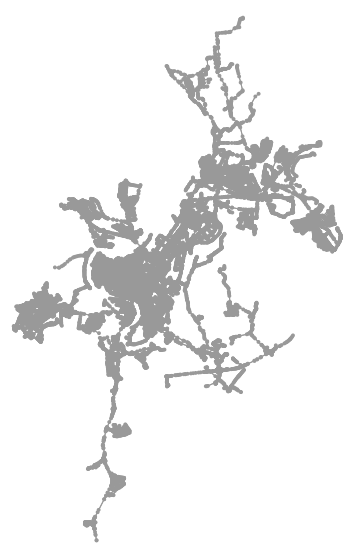

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
e = apartments_values[0].Succ.values()
route = min(attr.get(weight, 1) for attr in e.values())
ox.plot_graph_route(G, [315722456], fig_height=10, fig_width=10)

### Пункт 1.b
Для каждого дома определить объекты, расположенные не далее, чем в X км для каждого из трех вариантов “туда”, “обратно”, “туда и обратно”.

In [0]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов: "туда", "обратно" и "туда и обратно" 
# содержат своё количество индексов - это списки второго уровня,индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. 
def find_in_radius(dist_matrix, radius, apart_count=100):
    permissible_hosps = [[[] for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        for j in range(apart_count, len(dist_matrix)):
            if dist_matrix[i][j] <= radius:
                permissible_hosps[i][0].append(j)
            if dist_matrix[j][i] <= radius:
                permissible_hosps[i][1].append(j)
            if dist_matrix[i][j] + dist_matrix[j][i] <= radius:
                permissible_hosps[i][2].append(j)
    return permissible_hosps

In [0]:
# запуск программы, radius произвольный
radius = 500
find_in_radius(temp, radius)

### Пункт 2
Определить, какой из объектов расположен так, что расстояние между ним и самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [0]:
# возвращаемый список содержит три больницы - [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals(dist_matrix, apart_count=100):
    optimal_hosps = []
    tuda = np.array(dist_matrix[:apart_count]).transpose()[apart_count:]
    optimal_hosps.append(np.argmin(np.amax(tuda, 1)) + apart_count)
    suda = np.array(dist_matrix[apart_count:])[:, :apart_count]
    optimal_hosps.append(np.argmin(np.amax(suda, 1)) + apart_count)
    tuda_suda = tuda + suda
    optimal_hosps.append(np.argmin(np.amax(tuda_suda, 1)) + apart_count)
    return optimal_hosps

In [0]:
# запуск программы
opt = get_optimal_hospitals(temp)
print(opt)

[105, 105, 105]


### Пункт 3

Определить, для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна.

In [0]:
# возвращает id больницы
def min_sum_hosp(dist_matrix, apart_count=100):
    dist_sums = np.array(dist_matrix[apart_count:])[:, :apart_count]
    dist_sums = np.sum(dist_sums, 1)
    min_hosp = np.argmin(dist_sums) + apart_count
    hosp_id = get_id(nodes_numbers, index_nodes, min_hosp)
    return hosp_id

In [0]:
# запуск программы
min_hosp_id = min_sum_hosp(data)

NameError: ignored

### Пункт 4
Определить, для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.

In [0]:
# считаем вес дерева кратчаших путей
def tree_weight(tree, root, matrix):
    weight = 0
    for i in tree[root].keys():
        j = tree[root][i]
        weight += matrix[j][i]
    return weight

# нахождение дерева минимального веса, где корни - больницы
def minimal_tree_hospitals(tree, matrix, hospitals):
    min_value = 10**10
    root = 0
    for i in hospitals:
        temp = tree_weight(tree, str(i), matrix)
        print(i, temp)
        if temp < min_value:
            min_value = temp
            root = i
    return root

In [0]:
# загружаем наши деревья кратчайших путей
with open('short_path_tree.json') as f:
    short_path_tree = json.load(f)

# берем список деревьев (они в конце index_nodes, поэтому берем последние 10)
hospitals = index_nodes[:-10]

# ищем номер корня дерева минимального веса из больниц
min_tree_root = minimal_tree_hospitals(short_path_tree, data, hospitals)
hosp_id = get_id(nodes_numbers, index_nodes, min_tree_root)

KeyError: ignored

### Второе задание.
На карте случайным образом выбраны N узлов (домов) и один из объектов инфраструктуры.

### Пункт 1
Построить дерево кратчайших путей от объекта до выбранных узлов. Вычислить общую длину дерева, а также сумму кратчайших расстояний от объекта до всех заданных узлов.

In [0]:
print(hospitals_dict)

{87989951: 1338629556, 89665027: 1237275182, 89665061: 7512139535, 91695664: 2334187973, 91695726: 1388755403, 95408851: 826163319, 95408853: 826163319, 95408906: 1237275154, 95408978: 7512139535, 96550316: 1118418017}


In [0]:
choosen_hospital = {}
# просто выбираем рандомную больницу из hospitals_dict (я выбрала третью)
choosen_hospital = {89665061: 7512139535}
print(choosen_hospital)

{89665061: 7512139535}


In [0]:
# тут дейкстра которая проходит только по апартаментам, без больниц


In [0]:
distance_choosen = []
pred_choosen = {}
tree_choosen = {}
index = 7512139535
tree_choosen = dijkstra_heap(G, index)


### Пункт 2
Разбить выбранные узлы на кластеры, используя метод полной связи (сomplete-linkage clustering). Построить дендрограмму разбиения узлов.

In [0]:
import scipy